In [0]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, utils

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd gdrive/

/content/gdrive


In [4]:
cd 'My Drive'/

/content/gdrive/My Drive


In [5]:
cd ImageColorization/

/content/gdrive/My Drive/ImageColorization


In [6]:
train_data = datasets.CIFAR10('CIFAR10', train = True, 
                         transform = transforms.Compose([transforms.ToTensor()]),
                         download = True)

train_batch = torch.utils.data.DataLoader(train_data, batch_size = 100, shuffle = True)

Files already downloaded and verified


In [0]:
def real_data_target(size):
    return (torch.ones(size, 1, 3, 3)).to(device)

def fake_data_target(size):
    return (torch.zeros(size, 1, 3, 3)).to(device)

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("Running on cpu")

Tesla P100-PCIE-16GB


In [44]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #ENCODER
        
        self.convE1 = nn.Conv2d(1, 64, kernel_size = (3, 3), stride = 2, padding = 1)#32x32
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.convE2 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 2, padding = 1)#16x16
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.convE3 = nn.Conv2d(128, 256, kernel_size = (3, 3), stride = 2, padding = 1)#8x8
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.convE4 = nn.Conv2d(256, 512, kernel_size = (3, 3), stride = 2, padding = 1)#4x4
        self.batch_norm4 = nn.BatchNorm2d(512)
        self.convE5 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = 2, padding = 1)#2x2
        self.batch_norm5 = nn.BatchNorm2d(512)      
        
        #DECODER
        
        self.convT1 = nn.ConvTranspose2d(512, 512, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.batch_norm6 = nn.BatchNorm2d(512)
        self.convT2 = nn.ConvTranspose2d(1024, 256, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.batch_norm7 = nn.BatchNorm2d(256)
        self.convT3 = nn.ConvTranspose2d(512, 128, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.batch_norm8 = nn.BatchNorm2d(128)
        self.convT4 = nn.ConvTranspose2d(256, 64, kernel_size = (4, 4), stride = 2, padding = 1)
        #concat
        self.batch_norm9 = nn.BatchNorm2d(64)
        self.convT5 = nn.ConvTranspose2d(128, 3, kernel_size = (4, 4), stride = 2, padding = 1)
        
        
    def forward(self, x):
        
        
        #ENCODER
        
        x1 = F.leaky_relu(self.convE1(x))#16x16x64
        x1 = self.batch_norm1(x1)
        x1_concat = F.leaky_relu(self.convE2(x1))#8x8x128
        x1_concat = self.batch_norm2(x1_concat)
        x2 = F.leaky_relu(self.convE3(x1_concat))#4x4x256
        x2 = self.batch_norm3(x2)
        x2_concat = F.leaky_relu(self.convE4(x2))#2x2x512
        x2_concat = self.batch_norm4(x2_concat)
        x3 = F.leaky_relu(self.convE5(x2_concat))#1x1x512
        
        #DECODER
        
        x5 = F.leaky_relu(self.convT1(x3))#2x2x512
        x5 = self.batch_norm6(x5)
        x5 = torch.cat((x5, x2_concat), 1)#2x2x1024
        x5 = F.leaky_relu(self.convT2(x5))#4x4x512
        x5 = self.batch_norm7(x5)
        x5 = torch.cat((x5, x2), 1)#512
        x5 = F.leaky_relu(self.convT3(x5))#8x8x128
        x5 = self.batch_norm8(x5)
        x5 = torch.cat((x5, x1_concat), 1)#8x8x256
        x5 = F.leaky_relu(self.convT4(x5))#16x16x64
        x5 = self.batch_norm9(x5)
        x5 = torch.cat((x5, x1), 1)#16x16x128
        x5 = self.convT5(x5)#32x32x2
        
        return x5

generator = Generator()
generator.to(device)

Generator(
  (convE1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convE2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convE3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convE4): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convE5): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batch_norm5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm6)

In [45]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        #ENCODER
        
        self.convE1 = nn.Conv2d(4, 64, kernel_size = (3, 3), stride = 2, padding = 0)#16x16
        self.convE2 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = 2, padding = 0)#8x8
        self.convE3 = nn.Conv2d(128, 1, kernel_size = (3, 3), stride = 2, padding = 0)#4x4
        
        
    def forward(self, x):
        
        x1 = F.leaky_relu(self.convE1(x))
        x2 = F.leaky_relu(self.convE2(x1))
        x3 = torch.sigmoid(self.convE3(x2))        
        
        
        return x3

discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (convE1): Conv2d(4, 64, kernel_size=(3, 3), stride=(2, 2))
  (convE2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (convE3): Conv2d(128, 1, kernel_size=(3, 3), stride=(2, 2))
)

In [0]:
loss_function = torch.nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr = 0.0002)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr = 0.0002)

In [0]:
def train_generator(fake_image, target, gray):
    optimizer_generator.zero_grad()
    
    fake_image_d = torch.cat((fake_image, gray), 1)
    prediction_fake_image = discriminator.forward(fake_image_d)
    loss_fake_image = loss_function(prediction_fake_image, real_data_target(prediction_fake_image.size(0)))
    l1_loss = abs(fake_image - target)
    total_gen_loss = loss_fake_image #+ (100 * l1_loss)
    loss_fake_image.backward()
    
    optimizer_generator.step()
    
    return loss_fake_image

In [0]:
def train_discriminator(real_image, fake_image, gray):
    optimizer_discriminator.zero_grad()
    
    #training discriminator using real images
    real_image = torch.cat((real_image, gray), 1)
    prediction_real = discriminator.forward(real_image)
    loss_real_image = loss_function(prediction_real, real_data_target(prediction_real.size(0)))
    loss_real_image.backward(retain_graph=True)
    
    #training discriminator using fake image
    fake_image = torch.cat((fake_image, gray), 1)
    prediction_fake = discriminator.forward(fake_image)
    loss_fake_image = loss_function(prediction_fake, fake_data_target(prediction_fake.size(0)))
    loss_fake_image.backward()
    
    optimizer_discriminator.step()
    
    return loss_real_image + loss_fake_image, prediction_real, prediction_fake

In [0]:
count = 0
for m,v in train_batch:#each batch
    for j in range(len(m)):#each sample
        utils.save_image(torch.tensor(m[j]), os.path.join('pyTorch_cifar10' ,str(count)+'.png'))
        count+=1

/home/aditya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [0]:
EPOCHS = 1
path = '/home/aditya/Desktop/pix2pix/pyTorch_cifar10'
count = 0
for epoch in range(EPOCHS):
    for i in range(50000):
        path_image = os.path.join(path, str(count)+'.png')
        img = cv2.imread(path_image)
        gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = torch.tensor(np.reshape(gray_scale, [1,1,32,32]), dtype = torch.float).to(device) / 255.0
        real_image = torch.tensor(np.reshape(np.transpose(img, (2,0,1)), [1,3,32,32]), dtype = torch.float).to(device) / 255.0
        fake_image = generator.forward(gray)
        d_error, d_pred_real, d_pred_fake = train_discriminator(real_image, fake_image)

        fake_image = generator.forward(gray)
        g_error = train_generator(fake_image, real_image)
        
        count+=1
        if(count % 1000 == 0):
            print(str(count) + 'images done')

In [113]:
EPOCHS = 50
count = 0
gray_scale = torch.zeros([100,32,32])
for epoch in range(EPOCHS):
    for real_batch, _ in tqdm(train_batch):
        img = np.transpose(real_batch.detach().numpy(), (0,2,3,1))
        for i in range(100):
            gray_scale[i] = torch.tensor(cv2.cvtColor(img[i], cv2.COLOR_BGR2GRAY), dtype = torch.float)
        gray = torch.tensor(np.reshape(gray_scale, [100,1,32,32]), dtype = torch.float).to(device)
        fake_image = generator.forward(gray)
        real_batch = torch.tensor(real_batch).to(device)
        d_error, d_pred_real, d_pred_fake = train_discriminator(real_batch, fake_image, gray)

        fake_image = generator.forward(gray)
        g_error = train_generator(fake_image, real_batch, gray)
        
        count+=1
        
    print('EPOCH: ' + str(epoch) + 'Generator Loss: ' + str(g_error.data.cpu().numpy()) + ' Discriminator Loss: ' + str(d_error.data.cpu().numpy()))

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
  0%|          | 2/500 [00:00<00:40, 12.42it/s]

EPOCH: 0Generator Loss: 2.988757 Discriminator Loss: 0.56934935


  0%|          | 2/500 [00:00<00:40, 12.40it/s]

EPOCH: 1Generator Loss: 4.137913 Discriminator Loss: 0.4746101


  0%|          | 2/500 [00:00<00:40, 12.39it/s]

EPOCH: 2Generator Loss: 13.043186 Discriminator Loss: 0.41260263


  0%|          | 2/500 [00:00<00:40, 12.29it/s]

EPOCH: 3Generator Loss: 4.3036156 Discriminator Loss: 0.41311455


  0%|          | 2/500 [00:00<00:39, 12.49it/s]

EPOCH: 4Generator Loss: 11.542104 Discriminator Loss: 0.6155683


  0%|          | 2/500 [00:00<00:40, 12.41it/s]

EPOCH: 5Generator Loss: 7.370164 Discriminator Loss: 0.44785422


  0%|          | 2/500 [00:00<00:40, 12.44it/s]

EPOCH: 6Generator Loss: 12.2873745 Discriminator Loss: 0.17848375


  0%|          | 2/500 [00:00<00:40, 12.39it/s]

EPOCH: 7Generator Loss: 8.519688 Discriminator Loss: 0.16321686


  0%|          | 2/500 [00:00<00:40, 12.36it/s]

EPOCH: 8Generator Loss: 7.3383083 Discriminator Loss: 0.28084952


  0%|          | 2/500 [00:00<00:40, 12.39it/s]

EPOCH: 9Generator Loss: 1.1071111 Discriminator Loss: 1.3177302


  0%|          | 2/500 [00:00<00:40, 12.44it/s]

EPOCH: 10Generator Loss: 13.419071 Discriminator Loss: 0.06587663


  0%|          | 2/500 [00:00<00:40, 12.36it/s]

EPOCH: 11Generator Loss: 9.36951 Discriminator Loss: 0.3483336


  0%|          | 2/500 [00:00<00:40, 12.44it/s]

EPOCH: 12Generator Loss: 11.928684 Discriminator Loss: 0.1281426


  0%|          | 2/500 [00:00<00:41, 11.89it/s]

EPOCH: 13Generator Loss: 23.506266 Discriminator Loss: 0.08963889


  0%|          | 2/500 [00:00<00:40, 12.41it/s]

EPOCH: 14Generator Loss: 4.143149 Discriminator Loss: 0.2573148


  0%|          | 2/500 [00:00<00:40, 12.27it/s]

EPOCH: 15Generator Loss: 15.232094 Discriminator Loss: 0.066420406


  0%|          | 2/500 [00:00<00:40, 12.36it/s]

EPOCH: 16Generator Loss: 8.231199 Discriminator Loss: 0.12993278


  0%|          | 2/500 [00:00<00:39, 12.47it/s]

EPOCH: 17Generator Loss: 40.860283 Discriminator Loss: 0.012594739


  0%|          | 2/500 [00:00<00:40, 12.40it/s]

EPOCH: 18Generator Loss: 4.732943 Discriminator Loss: 0.29911116


  0%|          | 2/500 [00:00<00:39, 12.49it/s]

EPOCH: 19Generator Loss: 2.5366726 Discriminator Loss: 0.5884962


  0%|          | 2/500 [00:00<00:39, 12.47it/s]

EPOCH: 20Generator Loss: 2.6355186 Discriminator Loss: 1.046788


  0%|          | 2/500 [00:00<00:41, 12.08it/s]

EPOCH: 21Generator Loss: 11.6034355 Discriminator Loss: 0.09009208


  0%|          | 2/500 [00:00<00:39, 12.52it/s]

EPOCH: 22Generator Loss: 5.420183 Discriminator Loss: 0.2752304


  0%|          | 2/500 [00:00<00:40, 12.17it/s]

EPOCH: 23Generator Loss: 3.2387426 Discriminator Loss: 0.35843885


  0%|          | 2/500 [00:00<00:39, 12.50it/s]

EPOCH: 24Generator Loss: 6.7009254 Discriminator Loss: 0.13244446


  0%|          | 2/500 [00:00<00:39, 12.53it/s]

EPOCH: 25Generator Loss: 5.6709924 Discriminator Loss: 0.39673755


  0%|          | 2/500 [00:00<00:40, 12.44it/s]

EPOCH: 26Generator Loss: 2.4123335 Discriminator Loss: 0.79313874


  0%|          | 2/500 [00:00<00:40, 12.27it/s]

EPOCH: 27Generator Loss: 11.227427 Discriminator Loss: 0.11488532


  0%|          | 2/500 [00:00<00:40, 12.37it/s]

EPOCH: 28Generator Loss: 4.483266 Discriminator Loss: 0.26840886


  0%|          | 2/500 [00:00<00:40, 12.43it/s]

EPOCH: 29Generator Loss: 10.65311 Discriminator Loss: 0.05997573


  0%|          | 2/500 [00:00<00:41, 12.13it/s]

EPOCH: 30Generator Loss: 4.6234665 Discriminator Loss: 0.6354228


  0%|          | 2/500 [00:00<00:39, 12.52it/s]

EPOCH: 31Generator Loss: 11.751582 Discriminator Loss: 0.0994529


  0%|          | 2/500 [00:00<00:40, 12.37it/s]

EPOCH: 32Generator Loss: 5.8791165 Discriminator Loss: 0.110738575


  0%|          | 2/500 [00:00<00:39, 12.47it/s]

EPOCH: 33Generator Loss: 5.997742 Discriminator Loss: 0.24107449


  0%|          | 2/500 [00:00<00:40, 12.42it/s]

EPOCH: 34Generator Loss: 14.779117 Discriminator Loss: 0.2836653


  0%|          | 2/500 [00:00<00:40, 12.41it/s]

EPOCH: 35Generator Loss: 3.478741 Discriminator Loss: 0.76406866


  0%|          | 2/500 [00:00<00:39, 12.45it/s]

EPOCH: 36Generator Loss: 23.326153 Discriminator Loss: 0.042681813


  0%|          | 2/500 [00:00<00:39, 12.46it/s]

EPOCH: 37Generator Loss: 1.9523989 Discriminator Loss: 0.86036897


  0%|          | 2/500 [00:00<00:40, 12.29it/s]

EPOCH: 38Generator Loss: 18.889551 Discriminator Loss: 0.5115673


  0%|          | 2/500 [00:00<00:40, 12.37it/s]

EPOCH: 39Generator Loss: 5.808684 Discriminator Loss: 0.75979793


  0%|          | 2/500 [00:00<00:40, 12.34it/s]

EPOCH: 40Generator Loss: 14.780349 Discriminator Loss: 0.13801423


  0%|          | 2/500 [00:00<00:40, 12.39it/s]

EPOCH: 41Generator Loss: 2.204678 Discriminator Loss: 0.8442859


  0%|          | 2/500 [00:00<00:40, 12.22it/s]

EPOCH: 42Generator Loss: 6.0402913 Discriminator Loss: 0.26195443


  0%|          | 2/500 [00:00<00:40, 12.37it/s]

EPOCH: 43Generator Loss: 6.1668034 Discriminator Loss: 0.14814018


  0%|          | 2/500 [00:00<00:40, 12.30it/s]

EPOCH: 44Generator Loss: 37.971752 Discriminator Loss: 0.04088736


  0%|          | 2/500 [00:00<00:39, 12.45it/s]

EPOCH: 45Generator Loss: 21.223898 Discriminator Loss: 0.06256969


  0%|          | 2/500 [00:00<00:40, 12.40it/s]

EPOCH: 46Generator Loss: 34.92542 Discriminator Loss: 0.0172697


  0%|          | 2/500 [00:00<00:40, 12.34it/s]

EPOCH: 47Generator Loss: 2.368508 Discriminator Loss: 0.9709358


  0%|          | 2/500 [00:00<00:40, 12.33it/s]

EPOCH: 48Generator Loss: 3.9012089 Discriminator Loss: 0.7302947


100%|██████████| 500/500 [00:41<00:00, 11.96it/s]

EPOCH: 49Generator Loss: 13.027451 Discriminator Loss: 0.109550506


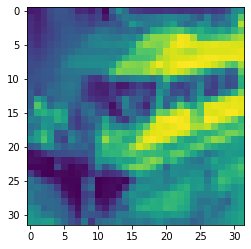

In [144]:
plt.imshow(gray[1][0].cpu().detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


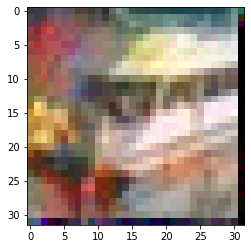

In [145]:
z = np.transpose(fake_image[1].cpu().detach().numpy(), (1,2,0))
plt.imshow(z)

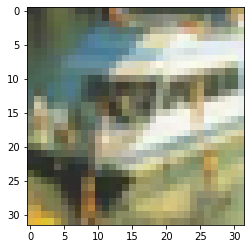

In [146]:
plt.imshow(img[1])

In [0]:
utils.save_image(fake_image, 'fake.png')

In [0]:
utils.save_image(gray, 'gray.png')